In [1]:
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist = input_data.read_data_sets('./Data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./Data/t10k-images-idx3-ubyte.gz
Extracting ./Data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm" 
        self.is_training = tf.placeholder(tf.bool, name="is_training")
        self.training_accuracies = []
        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.full_connected(layer_in, weights, activation_fn)
        self.output_layer = self.full_connected(layer_in, initial_weights[-1])
        
    def full_connected(self, layer_in, initial_weights, activation_fn=None):
        if self.use_batch_norm and activation_fn:
            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)
            bn_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
            
            return activation_fn(bn_output)
        else:
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            
            return linear_output if not activation_fn else activation_fn(linear_output)
        
    def train(self, session, learning_rate, training_batches, 
              batches_per_sample, save_model_as = None):
        labels = tf.placeholder(tf.float32, [None, 10])
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=self.output_layer, labels=labels))
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        for i in tqdm.tqdm(range(training_batches)):
            batch_xs, batch_ys = mnist.train.next_batch(60)
            
            session.run(train_step, feed_dict={self.input_layer: batch_xs,
                                              labels: batch_ys,
                                              self.is_training: True})
            if i % batches_per_sample == 0:
                validate_accuracy = session.run(
                    accuracy, feed_dict={self.input_layer: 
                                         mnist.validation.images,
                                         labels: mnist.validation.labels,
                                         self.is_training: False})
                self.training_accuracies.append(validate_accuracy)
        validate_accuracy = session.run(
            accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                labels: mnist.validation.labels,
                                self.is_training: False})
        print("{}:After traing, final accuracy on validation set={}".format(self.name, 
                                                                            validate_accuracy))
        if save_model_as:
            tf.train.Saver().save(session, save_model_as)
        
    def test(self, session, test_training_accuracy=False, 
             include_individual_predictions=False, restore_from=None):
        labels = tf.placeholder(tf.float32, [None, 10])
        correct_predict = tf.equal(tf.argmax(self.output_layer, 1),
                                  tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))
        
        if restore_from:
            tf.train.Saver().restore(sess, restore_from)
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                        labels: mnist.test.labels,
                                                        self.is_training: False})
        print('-'*75)
        print("{}:Accuracy on full test set={}".format(self.name, test_accuracy))
        
        if include_individual_predictions:
            predictions = []
            correct = 0
            
            for i in range(200):
                pred, corr = session.run([tf.argmax(self.output_layer, 1)],
                                        feed_dict = {self.layer_input:[mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    self.is_training: test_training_accuracy})
                correct += corr
                predictions.append(pred[0])
            print("200 predictions:", predictions)
            print("Accuracy on 200 samples:", correct/200)

In [13]:
def plot_training_accuracies(*args, **kwargs):
    fig, ax = plt.subplots()

    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies)*batches_per_sample,batches_per_sample),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()
    
def train_and_test(use_bad_weights, learning_rate, activation_fn, 
                   training_batches=50000, batches_per_sample=500):
    if use_bad_weights:
        weights = [
            np.random.normal(size=(784, 100),scale=5.0).astype(np.float32),
            np.random.normal(size=(100, 100),scale=5.0).astype(np.float32),
            np.random.normal(size=(100, 100),scale=5.0).astype(np.float32),
            np.random.normal(size=(100, 10),scale=5.0).astype(np.float32),
        ]
    else:
        weights = [
            # 784 * 100
            np.random.normal(size=(784, 100),scale=0.05).astype(np.float32),
            # 100 * 100
            np.random.normal(size=(100, 100),scale=0.05).astype(np.float32),
            # 100 * 100
            np.random.normal(size=(100, 100),scale=0.05).astype(np.float32),
            # 
            np.random.normal(size=(100, 10),scale=0.05).astype(np.float32),
        ]
    
    tf.reset_default_graph()
    nn = NeuralNet(weights, activation_fn, False)
    bn = NeuralNet(weights, activation_fn, True)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        nn.train(sess, learning_rate, training_batches, batches_per_sample)
        bn.train(sess, learning_rate, training_batches, batches_per_sample)
        
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn, bn, batches_per_sample=batches_per_sample)

100%|██████████| 50000/50000 [01:12<00:00, 694.36it/s]


Without Batch Norm:After traing, final accuracy on validation set=0.9778000116348267


100%|██████████| 50000/50000 [01:53<00:00, 440.03it/s]


With Batch Norm:After traing, final accuracy on validation set=0.9837999939918518
---------------------------------------------------------------------------
Without Batch Norm:Accuracy on full test set=0.972599983215332
---------------------------------------------------------------------------
With Batch Norm:Accuracy on full test set=0.9793999791145325


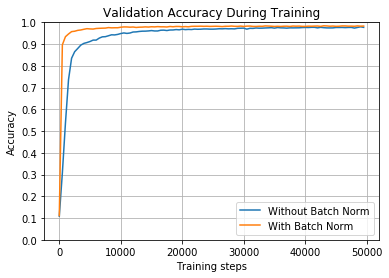

In [14]:
train_and_test(False, 0.01, tf.nn.relu)